# Warning
Because of the nature of the project, some of the contents of this project might be unpleasant.

# Introduction
Online communication has increased drastically in the last two decades. Nowadays, people use this medium to chat with family and friends, re-kindle old friendships, plan events, discuss their favourite topics, and much more. Despite all of this positive potentional, digital communication is unfortunately plagued with widespread hate speech and discrimination. In fact, a [Pew Research Center study](https://www.pewresearch.org/internet/2021/01/13/the-state-of-online-harassment/) found that 41% of US adults have experienced some form of online toxicity. Moreover, a majority of them also experienced severe harassment.

![https://www.pewresearch.org/internet/wp-content/uploads/sites/9/2021/01/PI_2021.01.13_online-harrasment_0-02a-1.png?w=640](https://www.pewresearch.org/internet/wp-content/uploads/sites/9/2021/01/PI_2021.01.13_online-harrasment_0-02a-1.png?w=640)

For the purposes of that study, researchers defined six forms of toxic behaviour: 
* Offensive name-calling
* Purposeful embarrassment
* Stalking
* Physical threats
* Harassment over a sustained period of time
* Sexual harassment

Many online platforms struggle to moderate conversations due to the large commitment required. Effective moderation requires a dedicated team of people whose sole job is to find and remove toxic users and their comments. This leads many online platforms to either limit, or completely shut down user communication.

# Task Description
The aim of this project is to create a tool that can help in the fight against online harassment. We will create a model that can not only decide whether a comment is toxic, but also describe the kind of toxicity that is present. This would allow online platforms to selectively remove the particular kind of toxicity they do not like. For example, an online community could be fine with mild swearing, but be completely opposed to obscenities.

In this project we will be working with a large dataset of Wikipedia comments that have been carefully labeled by human annotators. The possible labels for every comment are: toxic, severe_toxic, obscene, threat, insult, and identity hate. The task is to create a model that can correctly assign 0 or more of these labels to a piece of text. This means that essentially we are dealing with a multi-label binary classifcation problem, such that the output of the model is a vector of binary classification probabilities. 

# Install and Import Libraries
We start by intalling the transformers library. Huggingface provides this very useful library of pre-trained transformer models that can be fine-tuned on any task.

In [1]:
! pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
from typing import Tuple, List
from functools import partial

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence

from transformers import BertTokenizer, BertTokenizerFast, BertModel, AdamW, get_cosine_schedule_with_warmup, BertPreTrainedModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

import tqdm

import torch.backends.cudnn as cudnn
 
import math

import time
import random


# Extract Dataset

In [3]:
!unzip -o ../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
!unzip -o ../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
!unzip -o ../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
!unzip -o ../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip

Archive:  ../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: train.csv               
Archive:  ../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: test.csv                
Archive:  ../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  ../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
  inflating: sample_submission.csv   


# Configuration

In [4]:
CONFIG = {
    'train_path': './train.csv',
    'test_path': './test.csv',
    'test_label_path': './test_labels.csv',
    'sample_path': './sample_submission.csv',
    'epochs': 2,
    'batch_size': 16,
    'lr': 2e-5,
    'model_code': 'bert-base-uncased'
}


# Read CSV Files
In this section we start by reading the dataset csv files, and cleaning the test set.

In [5]:
train_csv = pd.read_csv(CONFIG['train_path'])
test_csv = pd.read_csv(CONFIG['test_path'])
test_label = pd.read_csv(CONFIG['test_label_path'])
test_full_csv = pd.merge(test_csv, test_label, on="id")
test_full_csv = test_full_csv.loc[test_full_csv["toxic"] != -1]

We visualise the training csv below to get an idea of its structure. This will help us understand how to extract the comments and process them into the form expected by the model.

In [6]:
train_csv.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Visualisation
In this section we will be visualising the training dataset in various ways. 

**Please beware that you could find these examples unpleasant. If so, please skip this section.**

## Class Word Clouds

In [7]:
from wordcloud import WordCloud,STOPWORDS

def generate_wordcloud_from_df(df, column):
    texts = []
    comments = train_csv.loc[df[column] == 1]['comment_text']
    for c in comments:
        texts.append(c)
    commonWord = ' '.join(texts)
    return WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1500,
                      height=1500
                     ).generate(commonWord)

train_toxic = generate_wordcloud_from_df(train_csv, 'toxic')
train_sev_toxic = generate_wordcloud_from_df(train_csv, 'severe_toxic')
train_obscene = generate_wordcloud_from_df(train_csv, 'obscene')
train_threat = generate_wordcloud_from_df(train_csv, 'threat')
train_insult = generate_wordcloud_from_df(train_csv, 'insult')
train_id_hate = generate_wordcloud_from_df(train_csv, 'identity_hate')

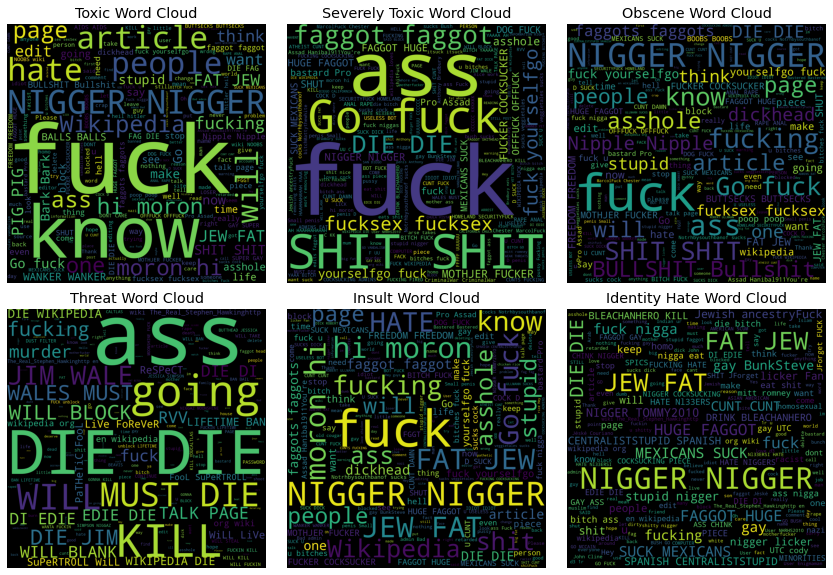

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), gridspec_kw = {'wspace':0.01, 'hspace':0.1})
axes[0][0].imshow(train_toxic)
axes[0][0].axis('off')
axes[0][0].set_title('Toxic Word Cloud')
axes[0][0].set_aspect('equal')

axes[0][1].imshow(train_sev_toxic)
axes[0][1].axis('off')
axes[0][1].set_title('Severely Toxic Word Cloud')
axes[0][1].set_aspect('equal')

axes[0][2].imshow(train_obscene)
axes[0][2].axis('off')
axes[0][2].set_title('Obscene Word Cloud')
axes[0][2].set_aspect('equal')

axes[1][0].imshow(train_threat)
axes[1][0].axis('off')
axes[1][0].set_title('Threat Word Cloud')
axes[1][0].set_aspect('equal')

axes[1][1].imshow(train_insult)
axes[1][1].axis('off')
axes[1][1].set_title('Insult Word Cloud')
axes[1][1].set_aspect('equal')

axes[1][2].imshow(train_id_hate)
axes[1][2].axis('off')
axes[1][2].set_title('Identity Hate Word Cloud')
axes[1][2].set_aspect('equal')

plt.show()

## Random Text Samples

In [9]:
def output_random_df_samples(df):
    length = len(df)
    rnd_indx = np.random.randint(0, length, 10)
    texts = df.loc[rnd_indx]['comment_text']
    for i, text in enumerate(texts.array):
        print(i+1, text, '\n')
    
output_random_df_samples(train_csv)

1 Fucking niggers thanks for wasting my time here,I'll just go back to vandalizing this shithole 

2 ": Add more contents to the article with reliable references. You may take help of search engines such as bing and Google for finding more information. But one thing you should keep in mind that your article should not violate the Wikipedia policy. Indian Talk  

" 

3 Feeling sorry about greeks 

I actually feel sorry for those greeks, loosing on all fronts and now here. Desperately trying to prove something in which, by most of the causes, it seems that they have no background.
I sure hope they will give up and let prosperity strikes among us, and not funny nationalistic issues. 

4 "

I think you're splitting too many hairs here.  It's very apparent that she and Summer are gonna have some business, and it's become obvious that she's graduated from from mere manager to a fighting diva.  People like Paul Heyman or Zeb Colter or Hogan/Lita/Gunn (Tough Enough) are there in non-physical r

## Class Counts

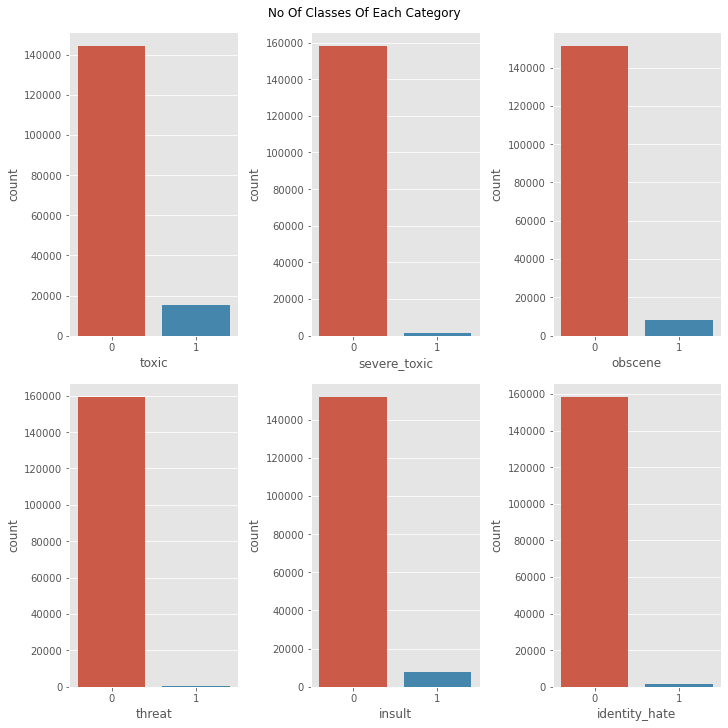

In [10]:
fig , axes = plt.subplots(2,3,figsize = (10,10), constrained_layout = True)
sns.countplot(ax=axes[0,0],x='toxic',data=train_csv )
sns.countplot(ax=axes[0,1],x='severe_toxic',data=train_csv)
sns.countplot(ax=axes[0,2],x='obscene',data=train_csv)
sns.countplot(ax = axes[1,0],x='threat',data=train_csv)
sns.countplot(ax=axes[1,1],x='insult',data=train_csv)
sns.countplot(ax=axes[1,2],x='identity_hate',data=train_csv)
plt.suptitle('No Of Classes Of Each Category')
plt.show()

# Dataset
In this section we present the dataset class we use during training. To reduce overhead costs whilst loading data, we take advantage of abundant system RAM and pre-process the datasets during initialisation. We use a method packaged with the transformers library to tokenize the full dataset using WordPiece, add special tokens ([CLS], [SEP], etc..), and convert the resulting tokens to vocabulary IDs. We also truncate the input text to a maximum length of 120 tokens.

In [11]:
class ToxicDataset(Dataset):
    
    def __init__(self, tokenizer, dataframe):
        self.tokenizer = tokenizer
        self.pad_idx = tokenizer.pad_token_id
        self.df = dataframe 
        
        self.X = []
        self.Y = []
        self.X_attn_msk = []

        tokenized_comments = tokenizer(list(self.df['comment_text'].array), 
                                       add_special_tokens=True,
                                       return_token_type_ids=False, 
                                       padding=False, 
                                       truncation=True, 
                                       verbose=True,
                                       max_length=120)
        self.X = tokenized_comments['input_ids']
        self.X_attn_msk = tokenized_comments['attention_mask']
        self.Y = self.df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values.tolist()
        
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        return  torch.LongTensor(self.X[index]), torch.FloatTensor(self.Y[index]),torch.LongTensor(self.X_attn_msk[index])

To take advantage of batch processing during training, dataset pre-processing normally includes adding [PAD] tokens to create fixed size matrices. Crucially, this means that our transformer will be forced to process maximum length batches, wasting precious resources. This is because the self-attention mechanism within most transformers scales quadratically to the batch input length, both in processing and memory.

We overcome this issue by creating a custom data collating function that pads each individual batch dynamically. In this function we dynamically pad the input sequences with 0s ([PAD] token ID), and generate the respective attention masking sequences. Attention masking is crucial in this scenario, as we want the self-attention mechanism to exclude the [PAD] tokens from its calculations. We thus significantly cut down on training time by transferring, storing, and processing smaller batches. Another common method used in practice is to group similar sized input sequences for even greater efficiency.

In [12]:
def collate_batch(batch):
    pad_val = 0
    x, y, attn_mask = zip(*batch)
    x = pad_sequence(x, padding_value=pad_val, batch_first=True)
    attn_mask = pad_sequence(attn_mask, padding_value=pad_val, batch_first=True)
    y = torch.stack(y)
    return x, y, attn_mask

Traditionally, NLP methods like tfidf, SVD, LDA etc.. perform significantly worse when the data is not clean. However, text normalisation might not necessarily be beneficial in this project since we are dealing with online comments. These are texts that have a high variance owing to their informality. We might encounter spelling mistakes, forgotten words, and unknown symbols. This means that it is possible for us to clean the training data using a specific rule-based technique, train the model on that curated and heavily altered textual distribution, then encounter a completely different distribution in test set. For example, we could have a rule to map 'byo' and 'oby' to 'boy' in the training set, resulting in a clean training dataset. However, we could then encounter 'bo' in the test set, a drastic change from the expected 'boy', resulting in worse generalisation performance. 

Popular ways to overcome this in deep learning are through random textual data augmentation that makes the model more robust to outliers. This includes 'simple' methods like word order swapping, word insertions (random, wordnet synonym), and intentional grammatical mistakes like random character switching in a word. Other methods include using contextual word embeddings to insert and replace words, using translation models to generate new training data through back-translation, as well as adversarial training techniques.  

In the future we plan on experimenting with some of the aforementioned techniques to see if they help us improve model performance.

# Model
In this project we fine-tune a pre-trained BERT model to classify the toxicity in comments. Specifically, we follow the work of [Devlin et al.](https://arxiv.org/abs/1810.04805) and concatenate the [CLS] token hidden vectors of the last 4 transformer layers. We then propagate the resulting vector through a two layer classification MLP.

In [13]:
class ToxicityClassifier(nn.Module):
    
    def __init__(self, model_code, num_classes):
        super().__init__()
        self.model_code = model_code
        self.num_classes = num_classes
        self.transformer = BertModel.from_pretrained(self.model_code)
        self.output_layer0 = nn.Linear(self.transformer.config.hidden_size*4, self.transformer.config.hidden_size)
        self.output_layer = nn.Linear(self.transformer.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, labels=None):
        outputs = self.transformer(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids, output_hidden_states=True)

        outputs = outputs[2][-4:]
        outhid0 = outputs[0][:,0,:]
        outhid1 = outputs[1][:,0,:]
        outhid2 = outputs[2][:,0,:]
        outhid3 = outputs[3][:,0,:]
        outputs = None
        cls_output = torch.hstack((outhid0, outhid1, outhid2, outhid3))
        
        cls_output = self.output_layer0(cls_output)
        cls_output = torch.tanh(cls_output)
        cls_output = self.output_layer(cls_output)
        return cls_output

# Experiment Builder
We fine-tune the BERT model using an AdamW optimiser, paired with a warm-up cosine LR scheduler for two epochs. For the loss function we use the expectation of the binary cross-entropy loss across every label. To score each prediction, we use the expected ROC-AUC score across labels.

### ROC-AUC Metric
The [Receiver Operating Characteristic](https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/#:~:text=The%20Area%20Under%20the%20Curve,the%20positive%20and%20negative%20classes.) curve, or ROC curve, visualises the performance of a binary classifier as its classification threshold is varied. It is a probability curve that plots the true-positive rate (sensitivity) against false-positive rate (1-specificity) at various threshold values. The Area Under the Curve (AUC) is a summary of the ROC curve, scoring the ability of a binary classifier to accurately predict classes. When AUC=1, the model can perfectly classify data, and when AUC=0, it always predicts the wrong class. 


In [14]:
class ExperimentBuilder(nn.Module):
    def __init__(self, network_model, num_epochs, train_data, val_data,
                 test_data, weight_decay_coefficient, lr, use_gpu):
        """
        Initializes an ExperimentBuilder object. Such an object takes care of running training and evaluation of a deep net
        on a given dataset. It also takes care of saving per epoch models and automatically inferring the best val model
        to be used for evaluating the test set metrics.
        :param network_model: A pytorch nn.Module which implements a network architecture.
        :param experiment_name: The name of the experiment. This is used mainly for keeping track of the experiment and creating and directory structure that will be used to save logs, model parameters and other.
        :param num_epochs: Total number of epochs to run the experiment
        :param train_data: An object of the DataProvider type. Contains the training set.
        :param val_data: An object of the DataProvider type. Contains the val set.
        :param test_data: An object of the DataProvider type. Contains the test set.
        :param weight_decay_coefficient: A float indicating the weight decay to use with the adam optimizer.
        :param use_gpu: A boolean indicating whether to use a GPU or not.
        """
        super(ExperimentBuilder, self).__init__()
    
        self.model = network_model
        self.criterion = nn.BCEWithLogitsLoss()
        
        if torch.cuda.device_count() > 1 and use_gpu:
            self.device = torch.cuda.current_device()
            self.model.to(self.device)
            self.model = nn.DataParallel(module=self.model)
            print('Use Multi GPU', self.device)
        elif torch.cuda.device_count() == 1 and use_gpu:
            self.device =  torch.cuda.current_device()
            self.model.to(self.device)  # sends the model from the cpu to the gpu
            print('Use GPU', self.device)
        else:
            print("use CPU")
            self.device = torch.device('cpu')  # sets the device to be CPU
            print(self.device)
        

        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        self.num_epochs = num_epochs
        self.warmup_steps = 10 ** 3
        self.total_steps = math.ceil((len(train_data)/CONFIG['batch_size'])) * (num_epochs+1)
        
        self.optimizer = AdamW(self.parameters(), lr=lr, weight_decay=weight_decay_coefficient, eps=1e-8)
        self.learning_rate_scheduler = get_cosine_schedule_with_warmup(self.optimizer, num_warmup_steps=self.warmup_steps, num_training_steps=self.total_steps)
        

        self.state = dict()
        self.starting_epoch = 0

    def get_num_parameters(self):
        total_num_params = 0
        for param in self.parameters():
            total_num_params += np.prod(param.shape)

        return total_num_params

    def get_optimiser(self):
        return self.optimizer  
    
    
    def run_train_iter(self, x, y, attn_mask):
        """
        Receives the inputs and targets for the model and runs a training iteration. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.train()
        x, y = x.to(device=self.device), y.to(device=self.device)  # send data to device as torch tensors
        attn_mask = attn_mask.to(device=self.device)
        out = self.model.forward(x, attention_mask=attn_mask)  # forward the data in the model

        loss = self.criterion(out, y)

        self.optimizer.zero_grad()  # set all weight grads from previous training iters to 0
        loss.backward()  # backpropagate to compute gradients for current iter loss
        self.optimizer.step()  # update network parameters
        self.learning_rate_scheduler.step()

        with torch.no_grad():
            out = torch.sigmoid(out)
        out = out.cpu().data.numpy()

        return loss.cpu().data.numpy(), out, y.cpu().data.numpy()
        
    def run_evaluation_iter(self, x, y, attn_mask):
        """
        Receives the inputs and targets for the model and runs an evaluation iterations. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.eval()  # sets the system to validation mode
        x, y = x.to(device=self.device), y.to(device=self.device)  # send data to device as torch tensors
        attn_mask = attn_mask.to(device=self.device)
        out = self.model.forward(x, attention_mask=attn_mask)  # forward the data in the model

        loss = self.criterion(out, y)
        
        with torch.no_grad():
            out = torch.sigmoid(out)
        out = out.cpu().data.numpy()
        
        return loss.cpu().data.numpy(), out, y.cpu().data.numpy()
                                                                            
    def run_experiment(self):
        """
        Runs experiment train and evaluation iterations, saving the model and best val model and val model accuracy after each epoch
        :return: The summary current_epoch_losses from starting epoch to total_epochs.
        """
        print('Starting Training')
        print('Model Parameters: {}'.format(self.get_num_parameters()))
        total_losses = {"train_acc": [], "train_loss": [], "val_acc": [],
                        "val_loss": []}  # initialize a dict to keep the per-epoch metrics
        best_test_metrics = {'f1':0, 'acc':0, 'loss':0}
        best_val_loss = math.inf
        epochs_since_improv = 0
        for i, epoch_idx in enumerate(range(self.starting_epoch, self.num_epochs)):
            epoch_start_time = time.time()
            current_epoch_losses = {"train_acc": [], "train_loss": [], "train_f1": [], 
                                    "val_acc": [], "val_loss": [], "val_f1": [],
                                    "test_acc": [], "test_loss": [], "test_f1": []}
            train_preds = list([])
            train_labels = list([])
            self.current_epoch = epoch_idx
            with tqdm.tqdm(total=len(self.train_data)) as pbar_train:  # create a progress bar for training
                for idx, (x, y, attn_mask) in enumerate(self.train_data):  # get data batches
                    loss, preds, labels = self.run_train_iter(x=x, y=y, attn_mask=attn_mask) # take a training iter step
                    train_preds += preds.tolist()
                    train_labels += labels.tolist()
                    current_epoch_losses["train_loss"].append(loss)  # add current iter loss to the train loss list
                    pbar_train.update(1)
                    pbar_train.set_description("Epoch {} - loss: {:.4f}".format(self.current_epoch, loss))
            train_preds = np.array(train_preds)
            train_labels = np.array(train_labels)
            print('\nTrain ROC')
            for i, name in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
                print(f"{name} roc_auc {roc_auc_score(train_labels[:, i], train_preds[:, i])}")
            avg_train_loss = np.mean(np.array(current_epoch_losses["train_loss"]))  
            print("Train Loss: {:.4f}".format(avg_train_loss))
        
        test_preds = list([])
        test_labels = list([])
        with tqdm.tqdm(total=len(self.test_data)) as pbar_test:  # ini a progress bar
            for (x, y, attn_mask) in self.test_data:  # sample batch
                loss, preds, labels = self.run_evaluation_iter(x=x, y=y, attn_mask=attn_mask)  # compute loss and accuracy by running an evaluation step
                test_preds += preds.tolist()
                test_labels += labels.tolist()
                current_epoch_losses["test_loss"].append(loss)  # save test loss
                pbar_test.update(1)  # update progress bar status
                pbar_test.set_description("loss: {:.4f}".format(loss))  # update progress bar string output

        test_preds = np.array(test_preds)
        test_labels = np.array(test_labels)
        print('\nTest ROC')
        avg_auc = 0
        for i, name in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
            auc = roc_auc_score(test_labels[:, i], test_preds[:, i])
            avg_auc += auc
            print(f"{name} roc_auc {auc}")
        avg_auc /= 6
        print('\nFinal Test AUC:', avg_auc)


# Experiment
In this section we run the actual experiment. We fine-tune the BERT model using an AdamW optimiser, paired with a warm-up cosine LR scheduler for two epochs. For the loss function we use the expectation of the binary cross-entropy loss across every label.

In [16]:
seed = 100
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
cudnn.deterministic = True
cudnn.benchmark = False

tokenizer = BertTokenizerFast.from_pretrained(CONFIG['model_code'])

train_set = ToxicDataset(tokenizer, train_csv)
train_loader = DataLoader(train_set, batch_size=CONFIG['batch_size'], shuffle=True, drop_last=False, num_workers=4, collate_fn=collate_batch)

test_set = ToxicDataset(tokenizer, test_full_csv)
test_loader = DataLoader(test_set, batch_size=CONFIG['batch_size']*2, shuffle=True, drop_last=False, num_workers=4, collate_fn=collate_batch)

model = ToxicityClassifier(model_code=CONFIG['model_code'], num_classes=6)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [17]:
exp = ExperimentBuilder(network_model=model, num_epochs=CONFIG['epochs'], train_data=train_loader, val_data=None,
                 test_data=test_loader, weight_decay_coefficient=0.0, lr=CONFIG['lr'], use_gpu=True)
exp.run_experiment()

  0%|          | 0/9974 [00:00<?, ?it/s]

Use GPU 0
Starting Training
Model Parameters: 111846918


Epoch 0 - loss: 0.0011: 100%|██████████| 9974/9974 [34:27<00:00,  4.82it/s]



Train ROC
toxic roc_auc 0.9769724489325828
severe_toxic roc_auc 0.9798375805824557
obscene roc_auc 0.9856374750840124
threat roc_auc 0.9642424221384471


  0%|          | 0/9974 [00:00<?, ?it/s]

insult roc_auc 0.9809137673222761
identity_hate roc_auc 0.9695696485016441
Train Loss: 0.0511


Epoch 1 - loss: 0.0027: 100%|██████████| 9974/9974 [34:26<00:00,  4.83it/s]



Train ROC
toxic roc_auc 0.989579700124941
severe_toxic roc_auc 0.9909418862561243
obscene roc_auc 0.9935321296211186
threat roc_auc 0.99315239603414


  0%|          | 0/2000 [00:00<?, ?it/s]

insult roc_auc 0.9904520911843704
identity_hate roc_auc 0.9917791852813946
Train Loss: 0.0345


loss: 0.1938: 100%|██████████| 2000/2000 [04:18<00:00,  7.75it/s]



Test ROC
toxic roc_auc 0.9744777895098491
severe_toxic roc_auc 0.9893470989392825
obscene roc_auc 0.9807908969089636
threat roc_auc 0.9957082348898021
insult roc_auc 0.9799887114864338
identity_hate roc_auc 0.9907301284002591

Final Test AUC: 0.9851738100224318


# Results
We obtain an average AUC score of 0.985

# Conclusion and Future Work
In this project we fine-tuned a pre-trained BERT model to classify the toxicity in online comments. We used the outputs of the last 4 transformer layers as a feature vector for classifcation. Through this method, we achieved an AUC score of 0.985! In the future, we plan on improving the generalisation of our model by making it more robust to the various outliers that are present in online comments.